## Preactivation Empirics

We want to understand what kind of RF maximizes the probability that preactivations from the desired class are greater in sign than those from the undesired class.
Some quick-and-dirty Desmos visualization suggested that localized might help, but I need to make this precise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from localization import datasets, models, samplers
import jax
import jax.numpy as jnp
from jax.scipy.special import erf as gain_function
from functools import partial

### Defining data

In [207]:
config_ = dict(
  # data config
  num_dimensions=400,
  xi1=20,
  xi2=10,
  num_exemplars=10000,
  support=(-1, 1), # defunct
  class_proportion=0.5,
)

high_gain = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), gain=3, **config_)
low_gain = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), gain=0.01, **config_)

### Testing out RFs

In [208]:
x, y = high_gain[:10000]
# x, y = low_gain[:1000]
x1 = x[y == 1]
x0 = x[y == 0]

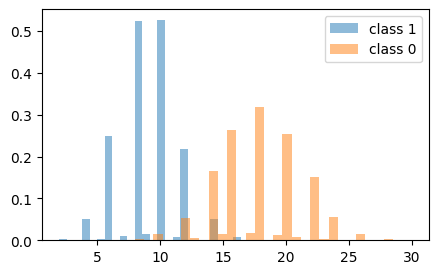

In [211]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
n1 = np.sum(np.sign(x1[:,:-1]) != np.sign(x1[:,1:]), axis=1)
n0 = np.sum(np.sign(x0[:,:-1]) != np.sign(x0[:,1:]), axis=1)
ax.hist(n1, bins=30, alpha=0.5, label='class 1', density=True)
ax.hist(n0, bins=30, alpha=0.5, label='class 0', density=True)
ax.legend()

#### Flat

In [159]:
w_flat = jnp.ones(config_['num_dimensions']) / config_['num_dimensions']
convolve_flat = jax.jit(
    jax.vmap(
        partial(
            jnp.convolve,
            v=w_flat,
            mode='same',
        )
    )
)

x1_flat = convolve_flat(x1).flatten() ** 2
x0_flat = convolve_flat(x0).flatten() ** 2
p_flat = jnp.mean(jnp.tile(x1_flat, (len(x0_flat), 1)) > jnp.tile(x0_flat, (len(x1_flat), 1)).T) 

Probability of x1_conv > x0_conv: 0.735


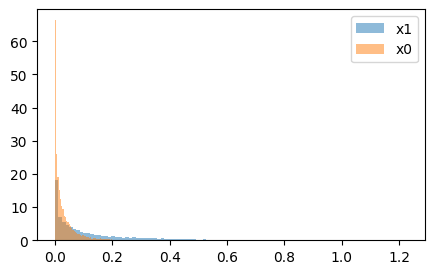

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(x1_flat, bins=100, alpha=0.5, label='x1', density=True)
ax.hist(x0_flat, bins=100, alpha=0.5, label='x0', density=True)
ax.legend()
print(f"Probability of x1_conv > x0_conv: {p_flat:.3f}")

#### Sinusoid

In [167]:
f = 0.5
w_sine = jnp.cos(2 * jnp.pi * f * jnp.arange(config_['num_dimensions']) / config_['num_dimensions'])
w_sine = w_sine / jnp.linalg.norm(w_sine)
convolve_sine = jax.jit(
    jax.vmap(
        partial(
            jnp.convolve,
            v=w_sine,
            mode='same',
        )
    )
)

x1_sine = convolve_sine(x1).flatten() ** 2
x0_sine = convolve_sine(x0).flatten() ** 2
p_sine = jnp.mean(jnp.tile(x1_sine, (len(x0_sine), 1)) > jnp.tile(x0_sine, (len(x1_sine), 1)).T)

Probability of x1_conv > x0_conv: 0.732


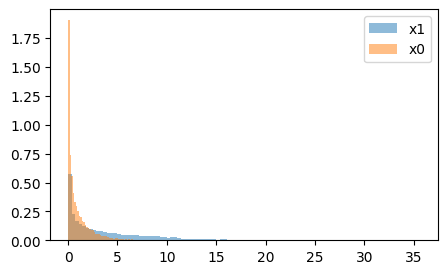

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(x1_sine, bins=100, alpha=0.5, label='x1', density=True)
ax.hist(x0_sine, bins=100, alpha=0.5, label='x0', density=True)
ax.legend()
print(f"Probability of x1_conv > x0_conv: {p_sine:.3f}")

#### Gabor

In [163]:
from localization.utils import gabor_real

In [169]:
w_gabor = gabor_real(
    c=1,
    b=0,
    a=0.5 * config_['num_dimensions'],
    x0=config_['num_dimensions']//2,
    k0=0.5 * 2 * np.pi / config_['num_dimensions'],
    x=jnp.arange(config_['num_dimensions']),
    n=config_['num_dimensions'],
)
w_gabor = w_gabor / jnp.linalg.norm(w_gabor)
convolve_gabor = jax.jit(
    jax.vmap(
        partial(
            jnp.convolve,
            v=w_gabor,
            mode='same',
        )
    )
)

x1_gabor = convolve_gabor(x1).flatten() ** 2
x0_gabor = convolve_gabor(x0).flatten() ** 2
p_gabor = jnp.mean(jnp.tile(x1_gabor, (len(x0_gabor), 1)) > jnp.tile(x0_gabor, (len(x1_gabor), 1)).T)

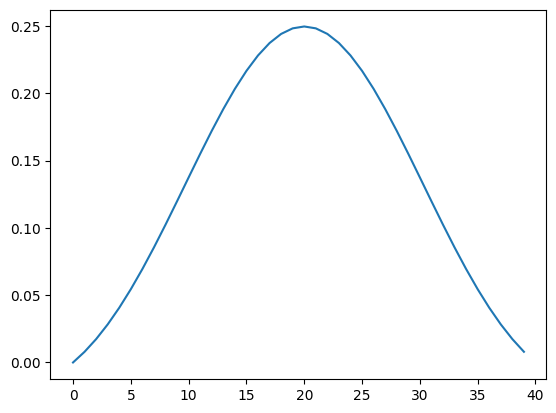

In [170]:
_ = plt.plot( w_gabor )

Probability of x1_conv > x0_conv: 0.742


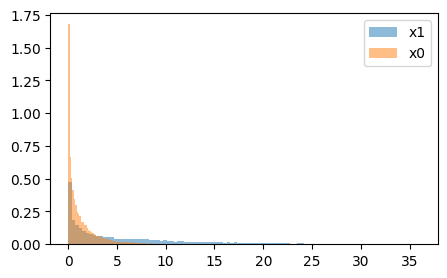

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(x1_gabor, bins=100, alpha=0.5, label='x1', density=True)
ax.hist(x0_gabor, bins=100, alpha=0.5, label='x0', density=True)
ax.legend()
print(f"Probability of x1_conv > x0_conv: {p_gabor:.3f}")

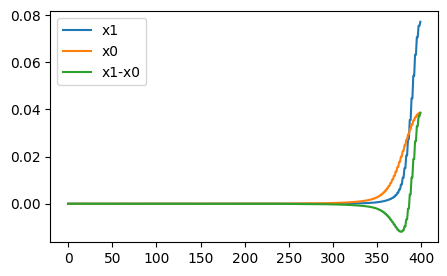

In [119]:
from localization.utils import build_non_gaussian_covariance
Sigma1 = build_non_gaussian_covariance(n=config_['num_dimensions'], xi=config_['xi1'], g=3)
Sigma0 = build_non_gaussian_covariance(n=config_['num_dimensions'], xi=config_['xi2'], g=3)


In [ ]:
evals1, evecs1 = jnp.linalg.eigh(Sigma1)
evals0, evecs0 = jnp.linalg.eigh(Sigma0)
evals1 = evals1 / config_['num_dimensions']
evals0 = evals0 / config_['num_dimensions']
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(evals1, label='x1')
ax.plot(evals0, label='x0')
ax.plot(evals1-evals0, label='x1-x0')
ax.legend()

### Visualizing single draws

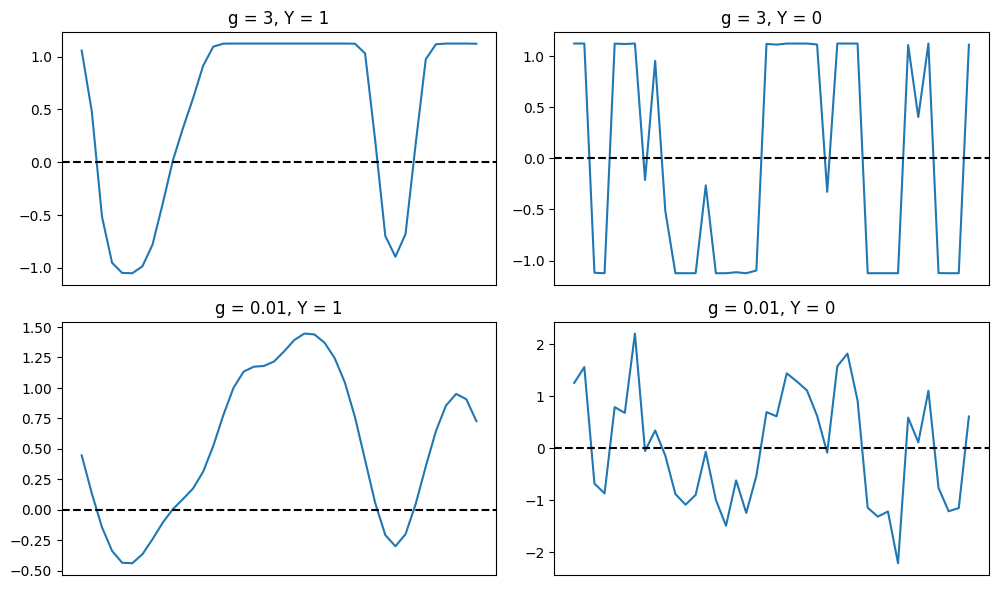

In [172]:
y_high = np.where(high_gain[:100][1])[0][0], np.where(1 - high_gain[:100][1])[0][0]
y_low = np.where(low_gain[:100][1])[0][0], np.where(1 - low_gain[:100][1])[0][0]

fig, axs = plt.subplots(2, 2, figsize=(10, 6))
for i, ax in enumerate(axs.flatten()):
  if i // 2 == 0:
    ax.plot(high_gain[:100][0][y_high[i % 2]])
    ax.set_title(f"g = 3, Y = {y_high[i % 2]}")
  else:
    ax.plot(low_gain[:100][0][y_low[i % 2]])
    ax.set_title(f"g = 0.01, Y = {y_low[i % 2]}")
  ax.axhline(0, color='k', linestyle='--')
  ax.set_xticks([])
# fig.suptitle("Example data from the nonlinear GP dataset")
fig.tight_layout()

### Number of zero crossings as a function of $\xi$

In [248]:
from tqdm import tqdm
n = 400
p = np.linspace(0.01, 0.6, 30)
crossings = np.zeros((len(p), 1000))

In [249]:
for i, p_ in tqdm(enumerate(p)):
    dataset = datasets.NonlinearGPDataset(
        key=jax.random.PRNGKey(0), 
        num_dimensions=n,
        xi1=int(p_*n),
        xi2=int(p_*n),
        num_exemplars=1000,
        support=(-1, 1), # defunct
        class_proportion=0.5,
        gain=3,
    )
    x = dataset[:1000][0]
    crossings[i] = np.sum(np.sign(x[:,:-1]) != np.sign(x[:,1:]), axis=1)


30it [00:44,  1.49s/it]


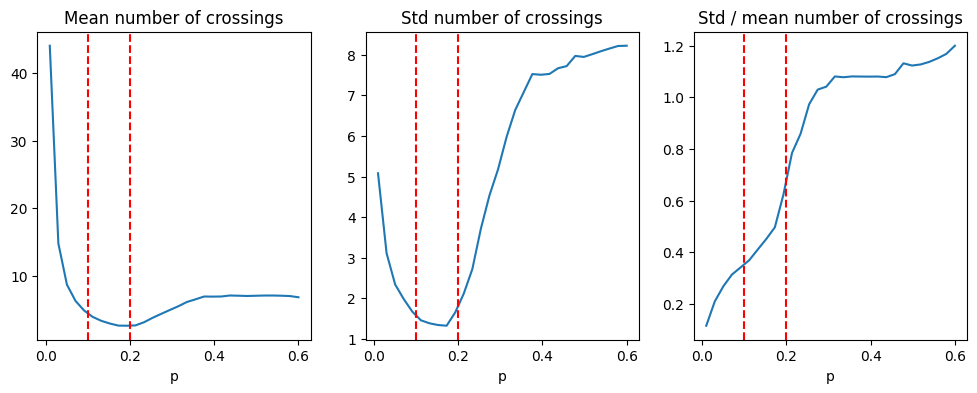

In [254]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.plot(p, np.mean(crossings, axis=1))
ax1.set_xlabel("p")
ax1.set_title("Mean number of crossings")
ax2.plot(p, np.std(crossings, axis=1))
ax2.set_title("Std number of crossings")
ax2.set_xlabel("p")
ax3.plot(p, np.std(crossings, axis=1) / np.mean(crossings, axis=1))
ax3.set_title("Std / mean number of crossings")
ax3.set_xlabel("p")
for ax in (ax1, ax2, ax3):
    ax.axvline(0.1, color='r', linestyle='--')
    ax.axvline(0.2, color='r', linestyle='--')